In [42]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal

In [43]:
from perlin_numpy import generate_fractal_noise_2d

In [44]:
'''
im: 2D array
x: [N,] float indices
y: [N,] float indices

from https://stackoverflow.com/questions/12729228/simple-efficient-bilinear-interpolation-of-images-in-numpy-and-python
'''
def bilinear_interpolate(im, x, y, period = False):
    x = np.asarray(x)
    y = np.asarray(y)

    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    if not period:
        x0 = np.clip(x0, 0, im.shape[0]-1);
        x1 = np.clip(x1, 0, im.shape[0]-1);
        y0 = np.clip(y0, 0, im.shape[1]-1);
        y1 = np.clip(y1, 0, im.shape[1]-1);

    if period:
        Ia = im[ x0 % im.shape[0], y0 % im.shape[1] ]
        Ib = im[ x0 % im.shape[0], y1 % im.shape[1] ]
        Ic = im[ x1 % im.shape[0], y0 % im.shape[1] ]
        Id = im[ x1 % im.shape[0], y1 % im.shape[1] ]
    else:
        Ia = im[ x0, y0 ]
        Ib = im[ x0, y1 ]
        Ic = im[ x1, y0 ]
        Id = im[ x1, y1 ]

    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    return wa*Ia + wb*Ib + wc*Ic + wd*Id

(256, 256)


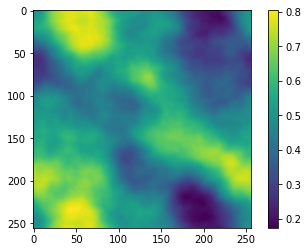

In [45]:
mapSize = 256

terrain = generate_fractal_noise_2d((mapSize, mapSize), (2, 2), 8, tileable = (True, True), persistence = 0.38)
terrain = terrain * 0.5 + 0.5
# _xs, _ys = np.meshgrid(np.linspace(0, mapSize, mapSize), np.linspace(0, mapSize, mapSize))
# terrain = (_xs + 0.6 * _ys)# + 8 * np.sin(_xs / 5.0 - 12.9) + 6 * np.sin(_ys / 4.0 + 0.88)
# terrain = (terrain - terrain.min()) / (terrain.max() - terrain.min()) * 0.8 + 0.2
# terrain = np.ones_like(terrain) * 0.5
plt.imshow(terrain)
plt.colorbar()

print(terrain.shape)

Water source: array([234,  44], dtype=int64)


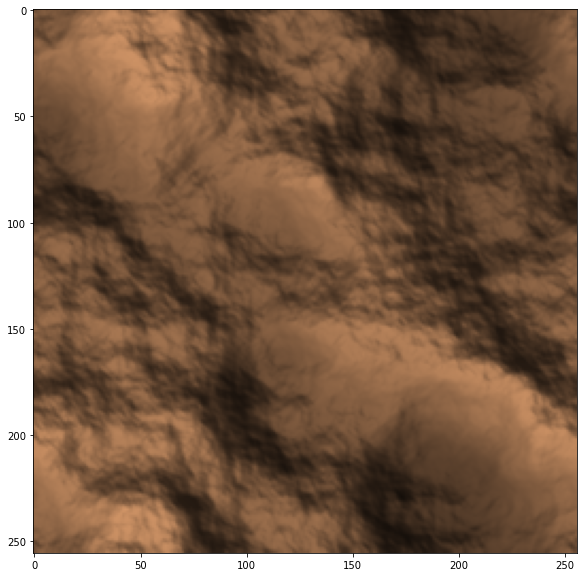

  0%|          | 0/2000 [00:00<?, ?it/s]

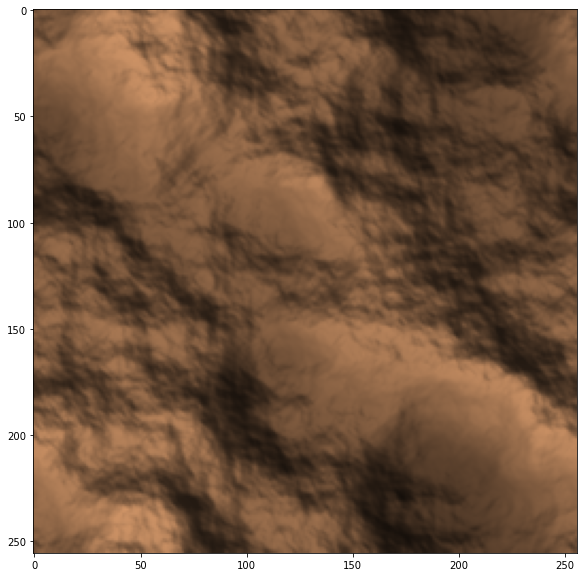

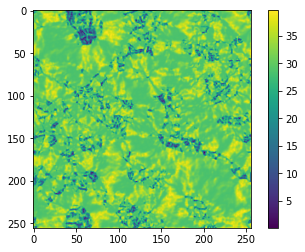

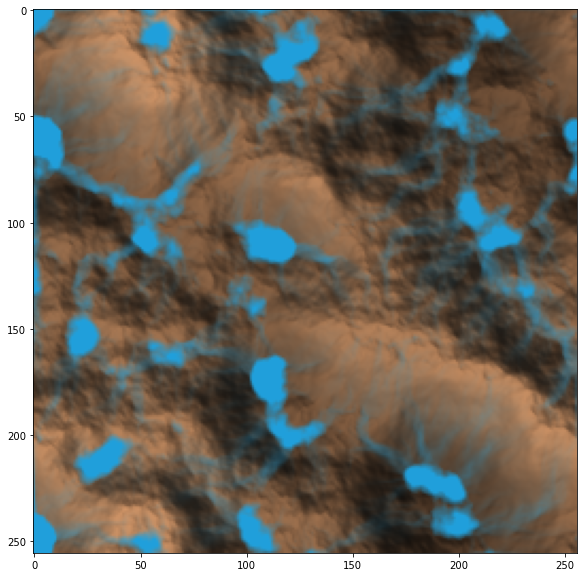

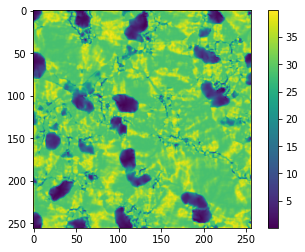

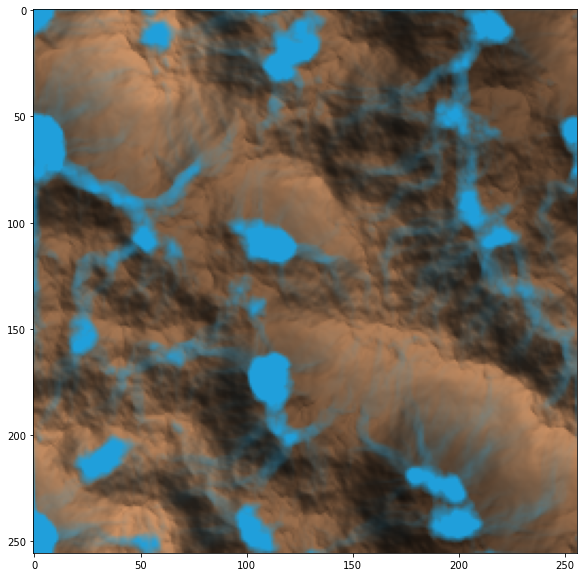

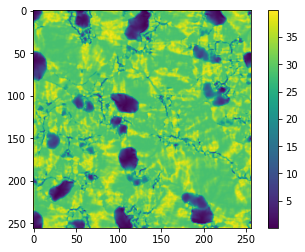

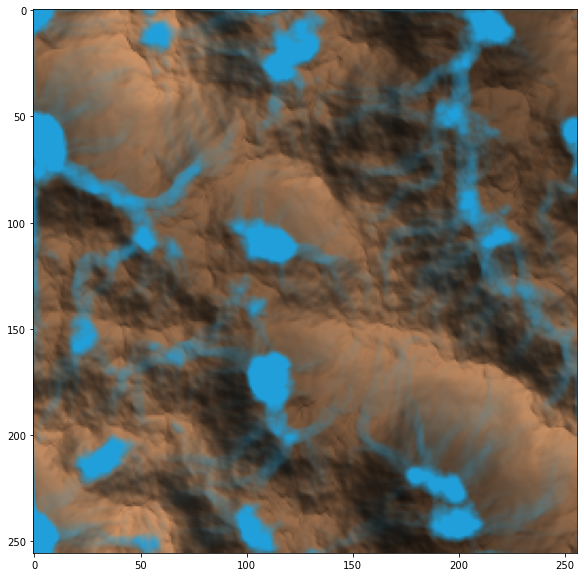

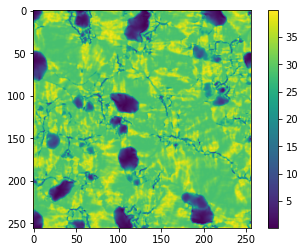

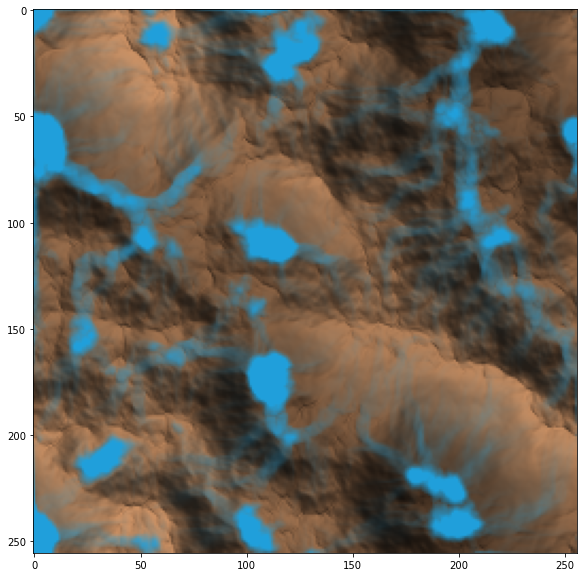

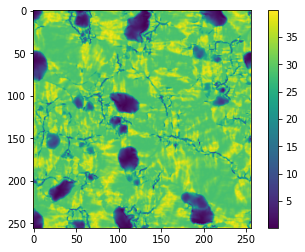

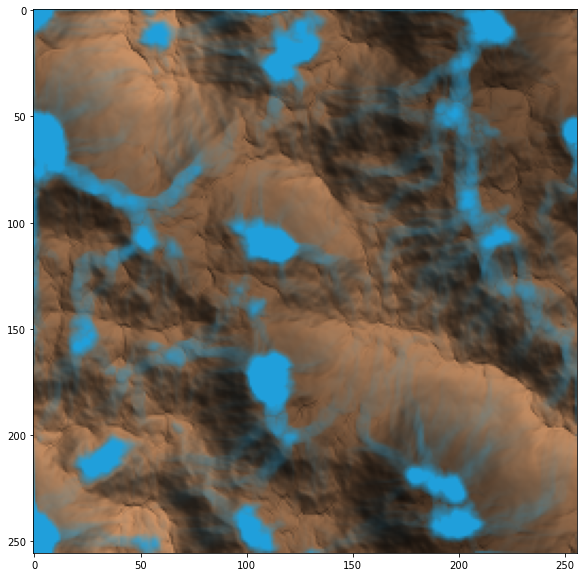

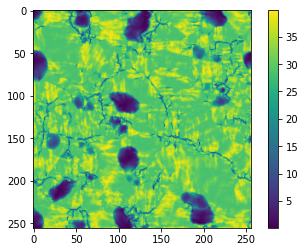

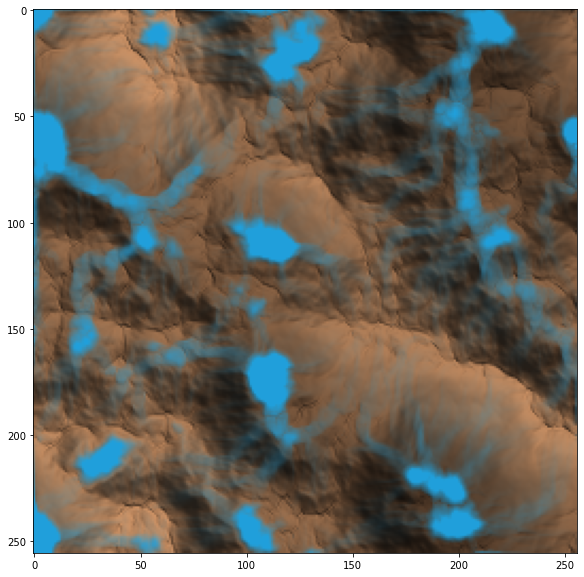

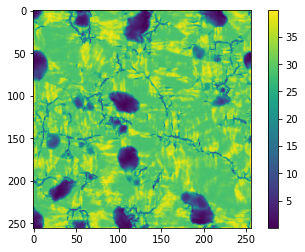

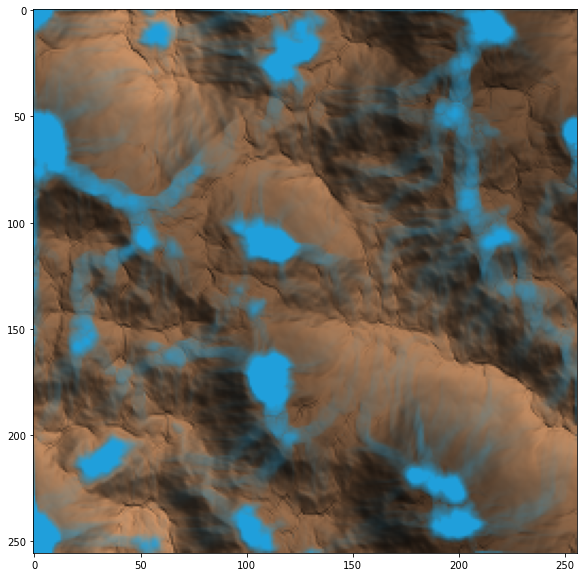

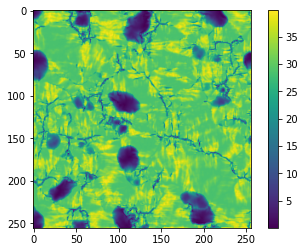

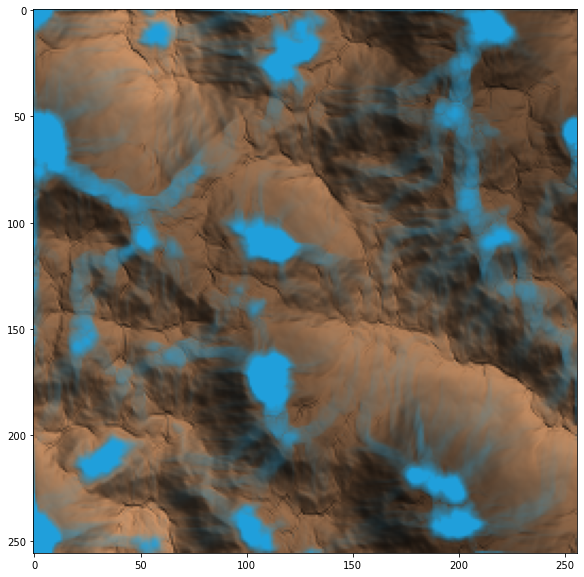

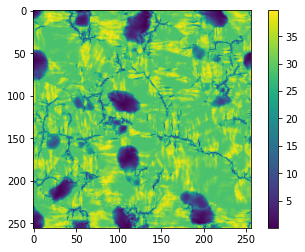

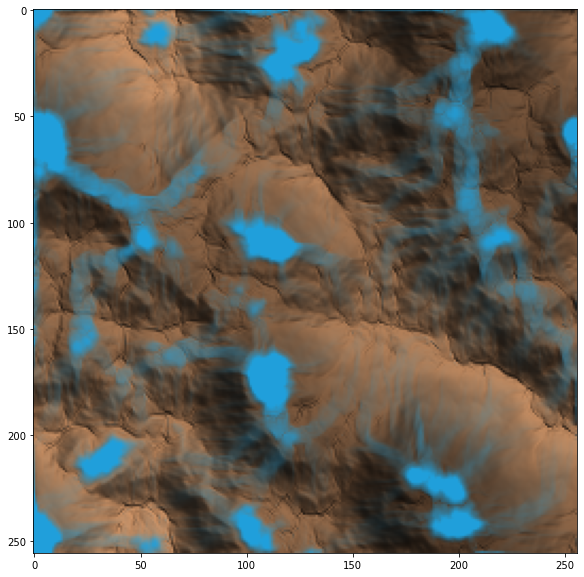

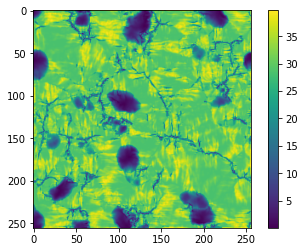

In [46]:
# Fast Hydraulic Erosion Simulation and Visualization on GPU, featureing a shallow water model and no particles were used.

from tqdm.notebook import tqdm

# Constant / parameters
hMax = mapSize / 2
# hMax = 1.0
dt = 0.05

A = 1.0 # Cross-sectional area of the pipe model for flow simulation
lPipe = 1.0 # Length of virtual pipe
lXY = 1.0 # Length of grid
g = 9.8 # Gravity acc
Kc = 0.1 # Sediment capacity constant
Ks = 0.02 # Dissolving constant
Kd = 0.013 # Deposition constant
Ke = 0.3 # Evaporation constant
alphaMin = 0.01 # Lower bound for surface slope

# Buffers
b = terrain * hMax # Terrain height
d = np.zeros_like(b) # Water height
s = np.zeros_like(d) # Sediment
f = np.zeros((mapSize, mapSize, 4)) # Out-flux in 4 directions: X+, X-, Y+, Y-
v = np.zeros((mapSize, mapSize, 2)) # Velocity in x, y

d1 = np.zeros_like(d) # for calculation

# r = np.ones_like(b) * 0.02 # Water amount per 1.0 time unit
r = np.power(b / hMax, 2.0) * 0.4 # Water amount per 1.0 time unit
# r = np.zeros_like(b)
rainAmount = 15.0
waterSourceAmount = 8.0

# Helper functions
_xs = np.linspace(0, mapSize * lXY, mapSize, endpoint = False)
_ys = np.linspace(0, mapSize * lXY, mapSize, endpoint = False)
cellPos = np.stack(np.meshgrid(_xs, _ys), axis = -1) # [mapSize, mapSize, 2] Cell positions

# Used to smooth the velocity
alpha = 5
normalizing = (alpha + 4.0)
veloSmoothKernel = np.array(
    [[0.0, 1.0 / normalizing, 0.0],
     [1.0 / normalizing, alpha / normalizing, 1.0 / normalizing],
     [0.0, 1.0 / normalizing, 0.0]])

# Water source
waterSrc = np.asarray(np.unravel_index(b.argmax(), b.shape))
dist_to_src = np.linalg.norm((cellPos - waterSrc[np.newaxis, np.newaxis, :]) / mapSize, axis = -1)
# waterSrc = (mapSize // 2, mapSize // 2)
# r[dist_to_src < 0.02] = waterSourceAmount
print("Water source: %s" % repr(waterSrc))

s_loss = 0

# print(cellPos)

def PhysicalPosToNumpyIndex(x, y):
    return x / lXY, y / lXY

def Visualize(terrainHeight, waterHeight):
    waterColor = np.asarray([0.129, 0.627, 0.859])
    soilColor = np.asarray([0.980, 0.698, 0.482])
    sundir = np.asarray([0.425, 0.849, -0.314])
    
    _g = np.gradient(terrainHeight)
    normal = np.stack([-_g[0], np.ones_like(_g[0]), -_g[1]], axis = -1)
    normal = normal / np.linalg.norm(normal, axis = -1, keepdims = True)
    
    # Height color
    terrainColor = soilColor[np.newaxis, np.newaxis, :] * np.maximum(0, (terrainHeight[:, :, np.newaxis] / hMax) * 0.8 + 0.2)
    
    NoL = np.maximum(0, (sundir[np.newaxis, np.newaxis, :] * normal).sum(axis = -1))
    terrainColor = np.expand_dims((NoL * 0.8 + 0.2), -1) * terrainColor
    
    waterCap = 2.0
    waterBlend = np.minimum(waterCap, waterHeight)[:, :, np.newaxis] / waterCap
    waterBlend = np.maximum(0, waterBlend)
    
    blendedColor = terrainColor * (1 - waterBlend) + waterColor[np.newaxis, np.newaxis, :] * waterBlend
#     blendedColor = terrainColor
    
    plt.figure(figsize=(10,10))
    plt.imshow(blendedColor)
#     plt.colorbar()
    plt.show()

Visualize(b, d)

# Iterative update
iters = 2000
for it in tqdm(range(iters)):
    
    ##### 1. Water Increment
    d = d + dt * r
    
    # Rain
#     rndidx = np.random.randint(mapSize, size = (1, 1, 2))
#     dist_to_rain = np.linalg.norm((cellPos - rndidx) / mapSize, axis = -1)
#     d[dist_to_rain < 0.008] += dt * rainAmount # Raindrop
    np.copyto(d1, d)
    
    ##### 2. Flow Simulation
    ### Flux
    h = b + d # Water surface height
    
    # Height differences
    dh_x = np.diff(h, n = 1, axis = 0, append = 0) # dh_x[i, j] = h[i+1, j] - h[i, j]
    dh_y = np.diff(h, n = 1, axis = 1, append = 0) # dh_y[i, j] = h[i, j+1] - h[i, j]
    
    dh_xp = - (dh_x) # i, j - i+1, j
    dh_xn = + np.roll(dh_x, +1, axis = 0)
    dh_yp = - (dh_y)
    dh_yn = + np.roll(dh_y, +1, axis = 1)
    
    dh = np.stack([dh_xp, dh_xn, dh_yp, dh_yn], axis = -1)
    
    # Compute flux
    f = np.maximum(0, (f * 0.9999) + dt * A * (g * dh) / lPipe)
    
    # Boundary conditions
    f[mapSize - 1, :, 0] = 0
    f[0, :, 1] = 0
    f[:, mapSize - 1, 2] = 0
    f[:, 0, 3] = 0
    
    _f = np.copy(f)
    
    # Flux scaling to avoid negative water amount
    K = np.minimum(1.0, d * lXY * lXY / (dt * (np.sum(f, axis = -1)) + 1e-10))
    f = f * np.expand_dims(K, axis = -1)
    
    ### Water surface & Velocity
    # TODO: np.roll -> array slice / just use torch or cuda lmao
    # Change in volume
    dv = dt * (
        # In-flux
        # Boundary conditions already handled so we are good
        np.roll(f[:, :, 0], +1, axis = 0) +
        np.roll(f[:, :, 1], -1, axis = 0) +
        np.roll(f[:, :, 2], +1, axis = 1) +
        np.roll(f[:, :, 3], -1, axis = 1) -
        
        # Out-flux
        np.sum(f, axis = -1)
    )
    
    # Adjust water height
    d = d + dv / (lXY * lXY)
    
    # Velocity
    dWx = np.roll(f[:, :, 0], +1, axis = 0) - f[:, :, 1] + f[:, :, 0] - np.roll(f[:, :, 1], -1, axis = 0)
    dWy = np.roll(f[:, :, 2], +1, axis = 1) - f[:, :, 3] + f[:, :, 2] - np.roll(f[:, :, 3], -1, axis = 1)
    d_avg = (d + d1) / 2
    
    v[:, :, 0] = dWx / (lXY * d_avg + 1e-10)
    v[:, :, 1] = dWy / (lXY * d_avg + 1e-10)
    
    # Dirty trick to smooth out the velocity (gooey erosion OoO)
    # from https://github.com/LanLou123/Webgl-Erosion/blob/master/src/shaders/sediment-frag.glsl
    v[:, :, 0] = signal.convolve2d(v[:, :, 0], veloSmoothKernel, boundary = 'symm', mode = 'same')
    v[:, :, 1] = signal.convolve2d(v[:, :, 1], veloSmoothKernel, boundary = 'symm', mode = 'same')
    
    ##### 3. Erosion / Deposition
    ### Sediment transport capacity
    grad = np.linalg.norm(np.stack(np.gradient(b), axis = -1), axis = -1)
    sinAlpha = grad / np.sqrt(grad ** 2 + 1 ** 2) # Here the np.gradient is independent of our step l
    sinAlpha = np.maximum(sinAlpha, alphaMin)
    C = Kc * sinAlpha * np.linalg.norm(v, axis = -1)
    
    ### Transport soil
    dissolve = C > s
    deposite = C <= s
    
    # Use different constants for dissolve & deposition
    b[dissolve] = b[dissolve] - dt * Ks * (C[dissolve] - s[dissolve])
    s[dissolve] = s[dissolve] + dt * Ks * (C[dissolve] - s[dissolve])
    
    b[deposite] = b[deposite] - dt * Kd * (C[deposite] - s[deposite])
    s[deposite] = s[deposite] + dt * Kd * (C[deposite] - s[deposite])
    
    ##### 4. Sediment Transportation
    backward_pos = cellPos - dt * v
    npXs, npYs = PhysicalPosToNumpyIndex(backward_pos[:, :, 0], backward_pos[:, :, 1])
    npXs = npXs.reshape(-1)
    npYs = npYs.reshape(-1)
    result = bilinear_interpolate(s, npXs, npYs, True).reshape(mapSize, mapSize)

    prev_s = s.sum()
    s = result
    new_s = s.sum()
    s_loss += prev_s - new_s
    
    ##### 5. Evaporation
    d = d * (1 - Ke * dt)
    # 

    if it % (iters // 10) == 0:
#         plt.imshow(np.linalg.norm(v, axis = -1))
#         plt.colorbar()
#         plt.show()
        Visualize(b, d)
#         print(b.sum() + s.sum())
#         print(b.sum() + s.sum() + s_loss)
#         plt.imshow(d)
        plt.imshow(np.linalg.norm(v, axis = -1))
#         plt.imshow(b, cmap = 'terrain')
#         plt.imshow(d)
#         plt.imshow(dh_xp)
#         plt.imshow(dh_xn)
#         plt.imshow(dh_yp)
#         plt.imshow(dh_yn)
#         plt.imshow(K * (C - s))
#         plt.imshow(s)
        plt.colorbar()
        plt.show()

In [ ]:
# SemiLagrange test
# Fast Hydraulic Erosion Simulation and Visualization on GPU, featureing a shallow water model and no particles were used.

from tqdm.notebook import tqdm

# Buffers
b = terrain * hMax # Terrain height
s = np.zeros_like(b) # Sediment
v = np.ones((mapSize, mapSize, 2)) * 101.8 # Velocity in x, y

# Helper functions
_xs = np.linspace(0, mapSize * l, mapSize, endpoint = False)
_ys = np.linspace(0, mapSize * l, mapSize, endpoint = False)
cellPos = np.stack(np.meshgrid(_xs, _ys), axis = -1) # [mapSize, mapSize, 2] Cell positions

def PhysicalPosToNumpyIndex(x, y):
    return x / l, y / l

# Semi-lagrange test
s = b
dt = 0.01

# Iterative update
iters = 100
for it in tqdm(range(iters)):
    
    ##### 4. Sediment Transportation
    backward_pos = cellPos - dt * v
    npXs, npYs = PhysicalPosToNumpyIndex(backward_pos[:, :, 0], backward_pos[:, :, 1])
    npXs = npXs.reshape(-1)
    npYs = npYs.reshape(-1)
    result = bilinear_interpolate(s, npXs, npYs, True).reshape(mapSize, mapSize)

#     print("==")
#     print(s.sum())
    s = result
#     print(s.sum())
#     print("==")

    if it % (iters // 10) == 0:
        print(s.sum())
        plt.imshow(s)
        plt.colorbar()
        plt.show()

In [ ]:
# Particle-based from https://nickmcd.me/2020/04/10/simple-particle-based-hydraulic-erosion/
# Hard to tune

from tqdm.notebook import tqdm

batch_size = 2
h = terrain
hMax = 64.0
pPos = np.random.uniform(0, mapSize, size = (batch_size, 2))
pVel = np.random.uniform(0.0, 0.0, size = (batch_size, 2))
pSed = np.zeros((batch_size,))
pVol = np.ones((batch_size,))

trace = np.zeros_like(h)

dXY = hMax / mapSize
g = 9.8
dt = 0.1
friction = 0.02
depositionRate = 3.0
evaporationRate = 0.1

# for compare
hOrg = np.copy(h)

for t in tqdm(range(50000)):
    
    # Particle pos
    pX = pPos[:, 0].astype(int)
    pY = pPos[:, 1].astype(int)
    
    # Surface gradient
    pH = h[pX, pY]
    pxp = h[(pX + 1) % mapSize, pY]
    pxn = h[(pX - 1) % mapSize, pY]
    pyp = h[pX, (pY + 1) % mapSize]
    pyn = h[pX, (pY - 1) % mapSize]

    pdZX = (pxp - pxn) / 2
    pdZY = (pyp - pyn) / 2
    pGrad = - np.stack([pdZX / dXY, pdZY / dXY], axis = -1)
    
    # Acceleration & Move the particle
    pAcc = pGrad / (pGrad + 1) * g
    pVel += pAcc * dt
    pPos += pVel * dt
    pVel *= (1.0 - dt * friction) # Apply some drag
    pPos = pPos % mapSize
    
    # Modify the terrain
    # New positions
    newpX = pPos[:, 0].astype(int)
    newpY = pPos[:, 1].astype(int)
    
    # Speed length
    pSpdNorm = np.linalg.norm(pVel, axis = -1)
    
    # Equilibrium
    c_eq = pVol * pSpdNorm * (pH - h[newpX, newpY]) * hMax
    c_eq = np.maximum(c_eq, 0)
    c_eq = np.minimum(c_eq, 1)
    
#     print(c_eq)
    
    # dC
    cdiff = c_eq - pSed
    
#     print(c_eq)
    
    # Mass Transfer
    pSed += dt * depositionRate * cdiff
    # h[pX, pY] = np.maximum(h[pX, pY] - dt * pVol * depositionRate * cdiff, 0.0)
    h[pX, pY] = h[pX, pY] - dt * pVol * depositionRate * cdiff
    
    # Evaporation
    pVol *= (1.0 - dt * evaporationRate)
    
    # Spawn new particles
    isDead = pVol <= 1e-3
    deadCount = isDead.sum()
    pPos[isDead] = np.random.uniform(0, mapSize, size = (deadCount, 2))
    pVel[isDead] = np.random.uniform(0, 0, size = (deadCount, 2))
    pVol[isDead] = np.random.uniform(0.8,1.2,size=(deadCount,))
    pSed[isDead] = 0.0
    
#     if deadCount > 0:
#         print(deadCount)
    
    # Markers
    trace[pX, pY] += 1.0
    
print("Original: %f" % hOrg.mean())
print("New: %f" % h.mean())
    
plt.figure(figsize=(12,12))
plt.imshow(abs(h - hOrg))
# plt.imshow(h)
# plt.imshow(trace, cmap = "gist_heat", alpha = 0.4)
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(h, cmap = 'terrain', vmax = 1.0, vmin = 0.0)

In [ ]:
plt.imshow(hOrg, cmap = 'terrain', vmax = 1.0, vmin = 0.0)
# print(np.asarray([0.5]) % 100)

In [54]:
# Unrelated konagaya buisness
import random

for i in range(143):
    print("%f, %f, %f, %f, %s" % (i / 143.0 / 3.0, 1.0, 0.0, 0.0, "Confocal/DiO/sample3_px70nm_Al488_TAMRA5_Z%03d_DiO.tif" % (i+1)))
    print("%f, %f, %f, %f, %s" % ((i + 0.5) / 143.0 / 3.0, 0.0, 1.0, 0.0, "Confocal/DiI/sample3_px70nm_Al488_TAMRA5_Z%03d_DiI.tif" % (i+1)))

0.000000, 1.000000, 0.000000, 0.000000, Confocal/DiO/sample3_px70nm_Al488_TAMRA5_Z001_DiO.tif
0.001166, 0.000000, 1.000000, 0.000000, Confocal/DiI/sample3_px70nm_Al488_TAMRA5_Z001_DiI.tif
0.002331, 1.000000, 0.000000, 0.000000, Confocal/DiO/sample3_px70nm_Al488_TAMRA5_Z002_DiO.tif
0.003497, 0.000000, 1.000000, 0.000000, Confocal/DiI/sample3_px70nm_Al488_TAMRA5_Z002_DiI.tif
0.004662, 1.000000, 0.000000, 0.000000, Confocal/DiO/sample3_px70nm_Al488_TAMRA5_Z003_DiO.tif
0.005828, 0.000000, 1.000000, 0.000000, Confocal/DiI/sample3_px70nm_Al488_TAMRA5_Z003_DiI.tif
0.006993, 1.000000, 0.000000, 0.000000, Confocal/DiO/sample3_px70nm_Al488_TAMRA5_Z004_DiO.tif
0.008159, 0.000000, 1.000000, 0.000000, Confocal/DiI/sample3_px70nm_Al488_TAMRA5_Z004_DiI.tif
0.009324, 1.000000, 0.000000, 0.000000, Confocal/DiO/sample3_px70nm_Al488_TAMRA5_Z005_DiO.tif
0.010490, 0.000000, 1.000000, 0.000000, Confocal/DiI/sample3_px70nm_Al488_TAMRA5_Z005_DiI.tif
0.011655, 1.000000, 0.000000, 0.000000, Confocal/DiO/sample3